In [1]:
import keras
import numpy as np
import requests
from datetime import datetime
from typing import List, Dict, Any

# from keras.src.backend.config import keras_home
# from prompt_toolkit.input import Input
from stock_indicators.indicators.common.quote import Quote
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class StockResponse:
    stock_data: List[Quote]

    def __init__(self, stock_data: List[Quote]):
        self.stock_data = stock_data

    @classmethod
    def from_json(cls, data: Dict[str, Any]) -> 'StockResponse':
        result = data["chart"]["result"][0]
        timestamps = result["timestamp"]
        indicators = result["indicators"]["quote"][0]

        stock_data: List[Quote] = []
        for i in range(len(timestamps)):
            date = datetime.fromtimestamp(timestamps[i])
            open_price = indicators["open"][i]
            high = indicators["high"][i]
            low = indicators["low"][i]
            close = indicators["close"][i]
            volume = indicators["volume"][i]

            # Skip if any value is None
            if 0 in (open_price, high, low, close, volume):
                continue

            stock_data.append(Quote(date, open_price, high, low, close, volume))

        return cls(stock_data=stock_data)

    def to_dataframe(self) -> pd.DataFrame:
        data = [[
            stock.date,
            stock.open,
            stock.high,
            stock.low,
            stock.close,
            stock.volume
        ] for stock in self.stock_data]
        return pd.DataFrame(data, columns=['date', 'open', 'high', 'low', 'close', 'volume'])

    def to_numpy(self) -> np.ndarray:
        data = [[
            stock.date,
            stock.open,
            stock.high,
            stock.low,
            stock.close,
            stock.volume
        ] for stock in self.stock_data]
        return np.array(data)

In [3]:
stock_url = "https://query2.finance.yahoo.com/v8/finance/chart/BBCA.JK?period1=1577836800&period2=1735689599&interval=1d"
headers = {
    "Content-Type": "application/json",
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
}

r = requests.get(stock_url, headers=headers)
r.json()

{'chart': {'result': [{'meta': {'currency': 'IDR',
     'symbol': 'BBCA.JK',
     'exchangeName': 'JKT',
     'fullExchangeName': 'Jakarta',
     'instrumentType': 'EQUITY',
     'firstTradeDate': 1086660000,
     'regularMarketTime': 1744881276,
     'hasPrePostMarketData': False,
     'gmtoffset': 25200,
     'timezone': 'WIB',
     'exchangeTimezoneName': 'Asia/Jakarta',
     'regularMarketPrice': 8500.0,
     'fiftyTwoWeekHigh': 10950.0,
     'fiftyTwoWeekLow': 7275.0,
     'regularMarketDayHigh': 8500.0,
     'regularMarketDayLow': 8350.0,
     'regularMarketVolume': 83540600,
     'longName': 'PT Bank Central Asia Tbk',
     'shortName': 'Bank Central Asia Tbk',
     'chartPreviousClose': 6685.0,
     'priceHint': 2,
     'currentTradingPeriod': {'pre': {'timezone': 'WIB',
       'start': 1744855200,
       'end': 1744855200,
       'gmtoffset': 25200},
      'regular': {'timezone': 'WIB',
       'start': 1744855200,
       'end': 1744881300,
       'gmtoffset': 25200},
      'po

# Checkpoint to restart from

In [4]:
json_data = r.json()
stock_response = StockResponse.from_json(json_data)
df   = stock_response.to_dataframe()
df

,date,open,high,low,close,volume
0,2020-01-02 09:00:00,6695.0,6780.0,6680.0,6690.0,49445000
1,2020-01-03 09:00:00,6750.0,6800.0,6725.0,6800.0,47755500
2,2020-01-06 09:00:00,6720.0,6750.0,6690.0,6735.0,27300000
3,2020-01-07 09:00:00,6735.0,6770.0,6730.0,6740.0,45022500
4,2020-01-08 09:00:00,6670.0,6745.0,6670.0,6680.0,53692500
...,...,...,...,...,...,...
1204,2024-12-20 09:00:00,9650.0,9750.0,9625.0,9650.0,91576900
1205,2024-12-23 09:00:00,9700.0,9850.0,9700.0,9775.0,43292100
1206,2024-12-24 09:00:00,9850.0,9900.0,9750.0,9750.0,32415700
1207,2024-12-27 09:00:00,9800.0,9825.0,9725.0,9800.0,24016700


In [5]:
# init variable for dataset to be used
# remove all column except for date and move the close price to y
df = stock_response.to_dataframe()
df = df.drop(columns=['open', 'high', 'low', 'volume'])

# Add column for the next day close price
df['next_day_price_move'] = df['close'].shift(-1)

# Drop the last row as it will have NaN in 'next_day_price_move'
df = df.drop(df.index[-1])

# Create the label with 3 classes
df['next_day_price_move'] = np.where(df['close'] < df['next_day_price_move'], 2, 
                                     np.where(df['close'] == df['next_day_price_move'], 1, 0))

# Ensure there are no invalid labels
assert df['next_day_price_move'].isin([0, 1, 2]).all(), "Invalid label found"

df

,date,close,next_day_price_move
0,2020-01-02 09:00:00,6690.0,2
1,2020-01-03 09:00:00,6800.0,0
2,2020-01-06 09:00:00,6735.0,2
3,2020-01-07 09:00:00,6740.0,0
4,2020-01-08 09:00:00,6680.0,2
...,...,...,...
1203,2024-12-19 09:00:00,9675.0,0
1204,2024-12-20 09:00:00,9650.0,2
1205,2024-12-23 09:00:00,9775.0,0
1206,2024-12-24 09:00:00,9750.0,2


# Define the Technical Indicators

In [6]:
from stock_indicators import indicators
stock_data = stock_response.stock_data # Holds the data in Quote object to be used for indicators
sma = indicators.get_sma(stock_data, 14)
rsi = indicators.get_rsi(stock_data, 14)
macd = indicators.get_macd(stock_data)
bollinger = indicators.get_bollinger_bands(stock_data, 20)
atr = indicators.get_atr(stock_data, 14)
wma = indicators.get_wma(stock_data, 14)
tr = indicators.get_tr(stock_data)
stoch_oscillator = indicators.get_stoch(stock_data)
william = indicators.get_williams_r(stock_data)
ema = indicators.get_ema(stock_data, 14)
obv = indicators.get_obv(stock_data)
ichimoku = indicators.get_ichimoku(stock_data)
vwap = indicators.get_vwap(stock_data)
smi = indicators.get_smi(stock_data)
dema = indicators.get_dema(stock_data, 14)
mfi = indicators.get_mfi(stock_data)
cci = indicators.get_cci(stock_data)
cmo = indicators.get_cmo(stock_data, 14)

In [7]:
# add above indicators to the dataset
for i in range(0, len(df)):
    df.loc[i, 'SMA'] = sma[i].sma
    df.loc[i, 'RSI'] = rsi[i].rsi
    df.loc[i, 'MACD'] = macd[i].macd
    df.loc[i, 'bollinger_upper'] = bollinger[i].upper_band
    df.loc[i, 'bollinger_lower'] = bollinger[i].lower_band
    df.loc[i, 'ATR'] = atr[i].atr
    df.loc[i, 'WMA'] = wma[i].wma
    df.loc[i, 'TR'] = tr[i].tr
    df.loc[i, '%K'] = stoch_oscillator[i].k
    df.loc[i, '%D'] = stoch_oscillator[i].d
    df.loc[i, '%R'] = william[i].williams_r
    df.loc[i, 'EMA'] = ema[i].ema
    df.loc[i, 'OBV'] = obv[i].obv
    df.loc[i, 'Ichimoku'] = ichimoku[i].kijun_sen
    df.loc[i, 'VWAP'] = vwap[i].vwap
    df.loc[i, 'SMI'] = smi[i].smi
    df.loc[i, 'DEMA'] = dema[i].dema
    df.loc[i, 'MFI'] = mfi[i].mfi
    df.loc[i, 'CCI'] = cci[i].cci
    df.loc[i, 'CMO'] = cmo[i].cmo

df

,date,close,next_day_price_move,SMA,RSI,MACD,bollinger_upper,bollinger_lower,ATR,WMA,...,%R,EMA,OBV,Ichimoku,VWAP,SMI,DEMA,MFI,CCI,CMO
0,2020-01-02 09:00:00,6690.0,2,None,None,None,None,None,None,None,...,None,None,0.0,None,6716.666667,None,None,None,None,None
1,2020-01-03 09:00:00,6800.0,0,None,None,None,None,None,None,None,...,None,None,47755500.0,None,6745.326370,None,None,None,None,None
2,2020-01-06 09:00:00,6735.0,2,None,None,None,None,None,None,None,...,None,None,20455500.0,None,6740.869280,None,None,None,None,None
3,2020-01-07 09:00:00,6740.0,0,None,None,None,None,None,None,None,...,None,None,65478000.0,None,6742.408970,None,None,None,None,None
4,2020-01-08 09:00:00,6680.0,2,None,None,None,None,None,None,None,...,None,None,11785500.0,None,6731.806968,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,2024-12-19 09:00:00,9675.0,0,10092.857143,37.424092,-84.331735,10469.016682,9648.483318,210.981941,10046.666667,...,-85.714286,10028.208032,-295062100.0,9987.5,7751.886892,-7.961127,9932.660208,44.421088,-192.664248,-15.294118
1204,2024-12-20 09:00:00,9650.0,2,10085.714286,36.879751,-106.950887,10487.633527,9609.866473,204.840374,9987.619048,...,-88.571429,9977.780294,-386639000.0,9987.5,7753.544046,-14.491946,9851.268141,52.276306,-166.85022,-5.263158
1205,2024-12-23 09:00:00,9775.0,0,10055.357143,41.464286,-113.48212,10491.822112,9598.177888,204.494633,9946.190476,...,-74.285714,9950.742922,-343346900.0,9987.5,7754.367175,-18.633865,9817.666666,48.336484,-115.452306,-26.984127
1206,2024-12-24 09:00:00,9750.0,2,10023.214286,40.825619,-119.300242,10484.042027,9563.457973,200.602159,9905.47619,...,-77.142857,9923.977199,-375762600.0,9987.5,7754.990689,-22.130776,9785.447484,44.704262,-91.914475,-28.125


## Handle dtypes

In [8]:
# Fill in the missing values or drop rows with NaN values
df = df.dropna()

# Convert columns to their appropriate data types
df = df.astype({
    'close': 'float64',
    'SMA': 'float64',
    'RSI': 'float64',
    'MACD': 'float64',
    'bollinger_upper': 'float64',
    'bollinger_lower': 'float64',
    'ATR': 'float64',
    'WMA': 'float64',
    'TR': 'float64',
    '%K': 'float64',
    '%D': 'float64',
    '%R': 'float64',
    'EMA': 'float64',
    'OBV': 'float64',
    'Ichimoku': 'float64',
    'VWAP': 'float64',
    'SMI': 'float64',
    'DEMA': 'float64',
    'MFI': 'float64',
    'CCI': 'float64',
    'CMO': 'float64',
    'next_day_price_move': 'int64'
})

# Verify the data types
print(df.dtypes)
df

date                   datetime64[ns]
close                         float64
next_day_price_move             int64
SMA                           float64
RSI                           float64
MACD                          float64
bollinger_upper               float64
bollinger_lower               float64
ATR                           float64
WMA                           float64
TR                            float64
%K                            float64
%D                            float64
%R                            float64
EMA                           float64
OBV                           float64
Ichimoku                      float64
VWAP                          float64
SMI                           float64
DEMA                          float64
MFI                           float64
CCI                           float64
CMO                           float64
dtype: object


,date,close,next_day_price_move,SMA,RSI,MACD,bollinger_upper,bollinger_lower,ATR,WMA,...,%R,EMA,OBV,Ichimoku,VWAP,SMI,DEMA,MFI,CCI,CMO
25,2020-02-06 09:00:00,6740.0,2,6735.714286,52.753967,-54.960927,6997.634173,6522.365827,127.769813,6691.666667,...,-38.842975,6704.554183,-61767500.0,6715.0,6746.250051,-29.020779,6659.670099,47.823033,-33.594260,-16.564417
26,2020-02-07 09:00:00,6760.0,2,6730.357143,53.920062,-45.968472,6998.842282,6524.657718,124.000541,6694.904762,...,-31.578947,6711.946959,20841500.0,6715.0,6746.329174,-23.172825,6679.454491,47.337961,-21.580863,-9.433962
27,2020-02-10 09:00:00,6785.0,0,6727.142857,55.401830,-36.404943,7000.918189,6526.581811,126.214788,6702.190476,...,-27.192982,6721.687364,87420000.0,6715.0,6745.943189,-17.085685,6701.968910,48.725579,-32.457496,-5.521472
28,2020-02-11 09:00:00,6780.0,2,6722.857143,55.020756,-28.896138,6991.548838,6526.951162,120.056589,6709.238095,...,-28.070175,6729.462383,9893500.0,6715.0,6746.747370,-11.486588,6719.111405,48.022588,-1.785183,-7.407407
29,2020-02-12 09:00:00,6800.0,0,6720.000000,56.315134,-21.088429,6988.010303,6526.989697,114.338261,6719.523810,...,-24.561404,6738.867398,79865000.0,6715.0,6747.916494,-6.000627,6738.047564,54.138487,16.701461,-4.819277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1203,2024-12-19 09:00:00,9675.0,0,10092.857143,37.424092,-84.331735,10469.016682,9648.483318,210.981941,10046.666667,...,-85.714286,10028.208032,-295062100.0,9987.5,7751.886892,-7.961127,9932.660208,44.421088,-192.664248,-15.294118
1204,2024-12-20 09:00:00,9650.0,2,10085.714286,36.879751,-106.950887,10487.633527,9609.866473,204.840374,9987.619048,...,-88.571429,9977.780294,-386639000.0,9987.5,7753.544046,-14.491946,9851.268141,52.276306,-166.850220,-5.263158
1205,2024-12-23 09:00:00,9775.0,0,10055.357143,41.464286,-113.482120,10491.822112,9598.177888,204.494633,9946.190476,...,-74.285714,9950.742922,-343346900.0,9987.5,7754.367175,-18.633865,9817.666666,48.336484,-115.452306,-26.984127
1206,2024-12-24 09:00:00,9750.0,2,10023.214286,40.825619,-119.300242,10484.042027,9563.457973,200.602159,9905.476190,...,-77.142857,9923.977199,-375762600.0,9987.5,7754.990689,-22.130776,9785.447484,44.704262,-91.914475,-28.125000


# Feature Selection with Recursive Feature Elimination (RFE)

In [9]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Prepare features and target
X = df.loc[:, (df.columns != 'next_day_price_move') & (df.columns != 'date') & (df.columns != 'close')]
y = df['next_day_price_move']  # 0 = down, 1 = same, 2 = up

# Use a classifier suitable for multiclass
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Select top N features (e.g., 5)
selector = RFE(estimator=model, n_features_to_select=5)
selector = selector.fit(X, y)

# Get selected features
selected_features = X.columns[selector.support_]
# dummy selected_features if I want to try all the features
# selected_features = X.columns
# selected_features = ['%K', '%D', '%R', 'MFI', 'CCI', 'CMO']
print("Selected features:", selected_features.tolist())

# Filter dataset with selected features
X = df[selected_features]


# # Optianlly, using RFECV
# from sklearn.feature_selection import RFECV
# from sklearn.model_selection import StratifiedKFold
# 
# model = RandomForestClassifier(n_estimators=100, random_state=42)
# cv = StratifiedKFold(n_splits=5)
# 
# rfecv = RFECV(estimator=model, step=1, cv=cv, scoring='accuracy')
# rfecv.fit(X, y)
# 
# selected_features = X.columns[rfecv.support_]
# print("Optimal number of features:", rfecv.n_features_)
# print("Selected features:", selected_features.tolist())
# 
# X = df[selected_features]

Selected features: ['MACD', 'ATR', '%K', 'MFI', 'CCI']


# Visualize the selected features

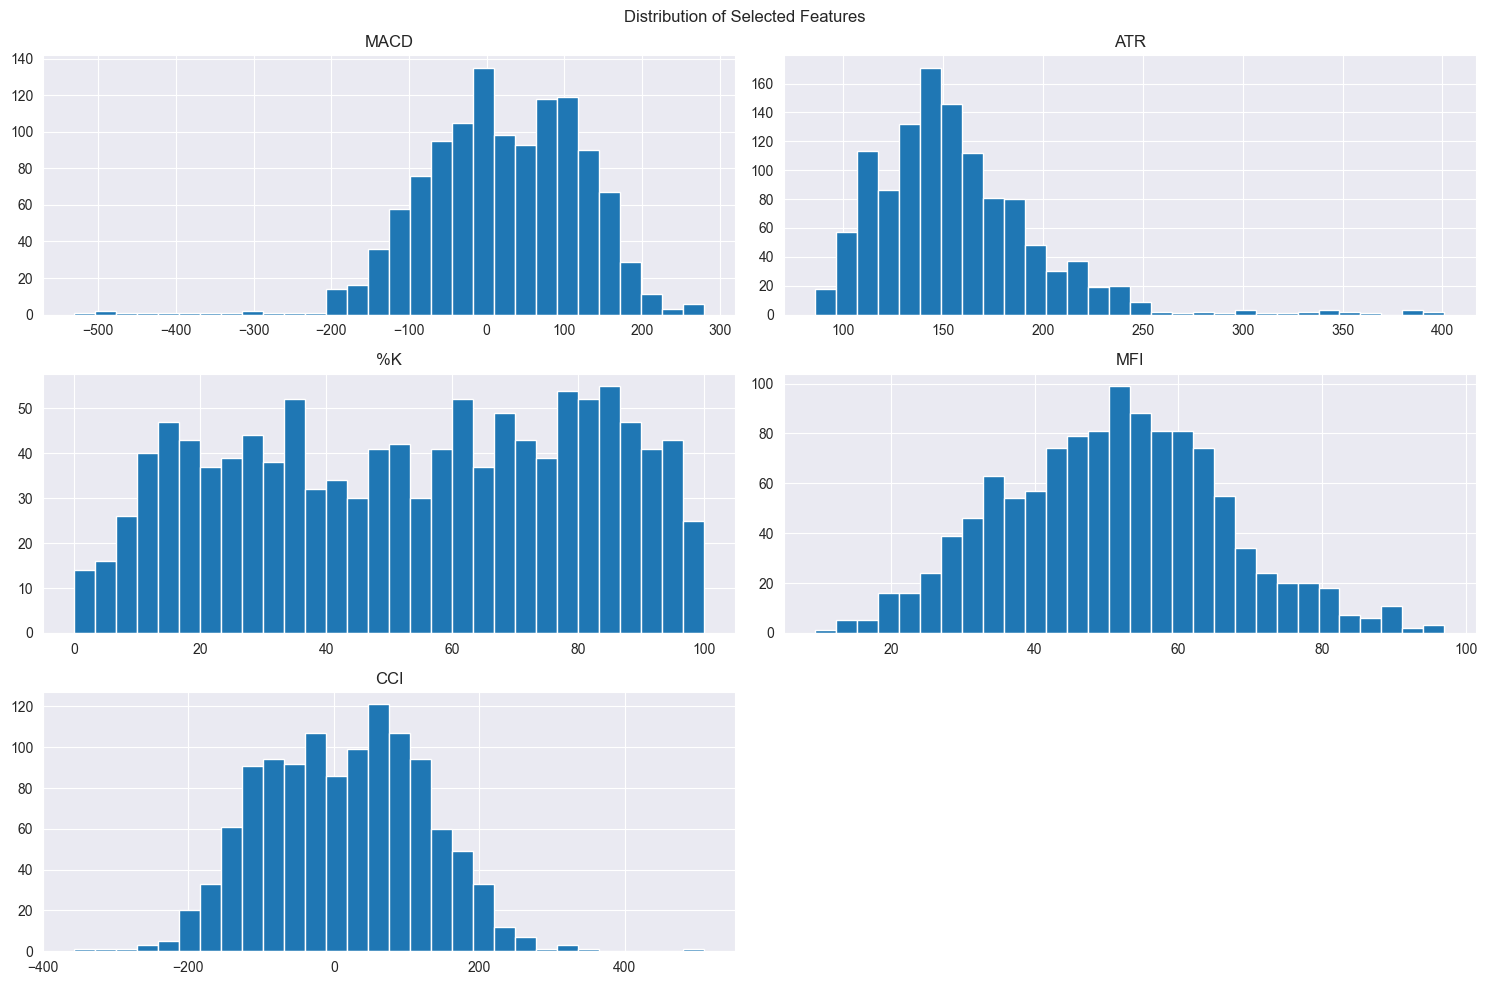

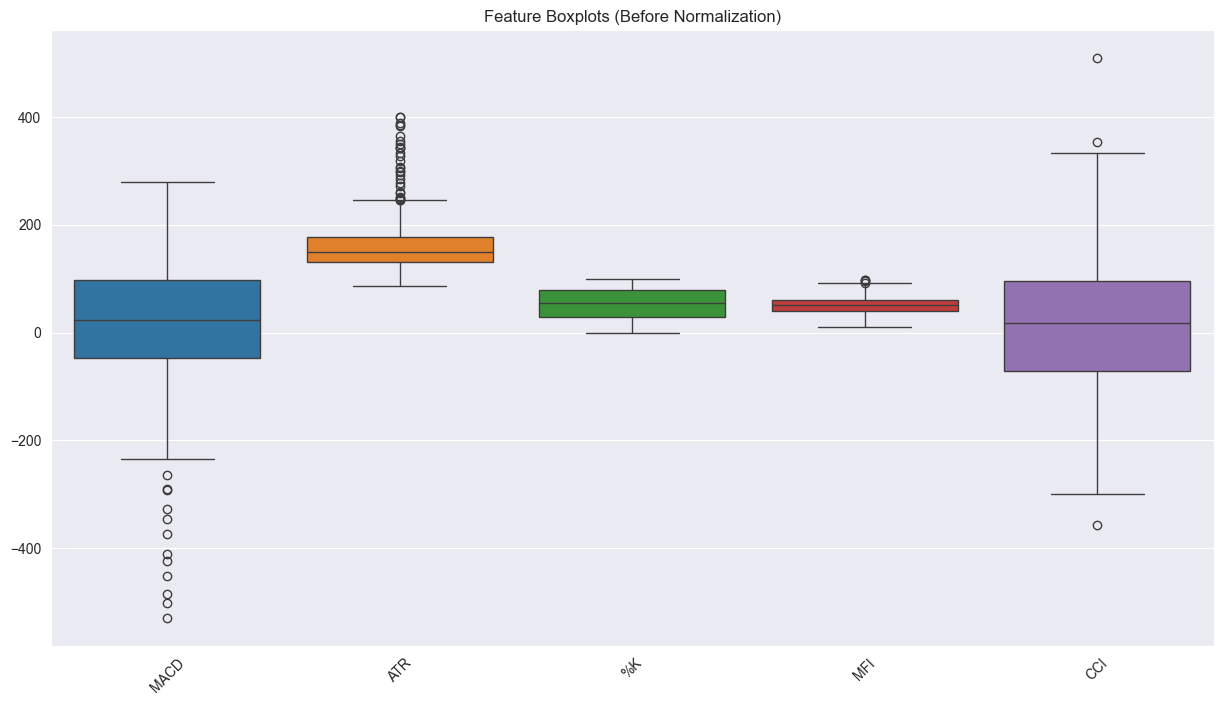

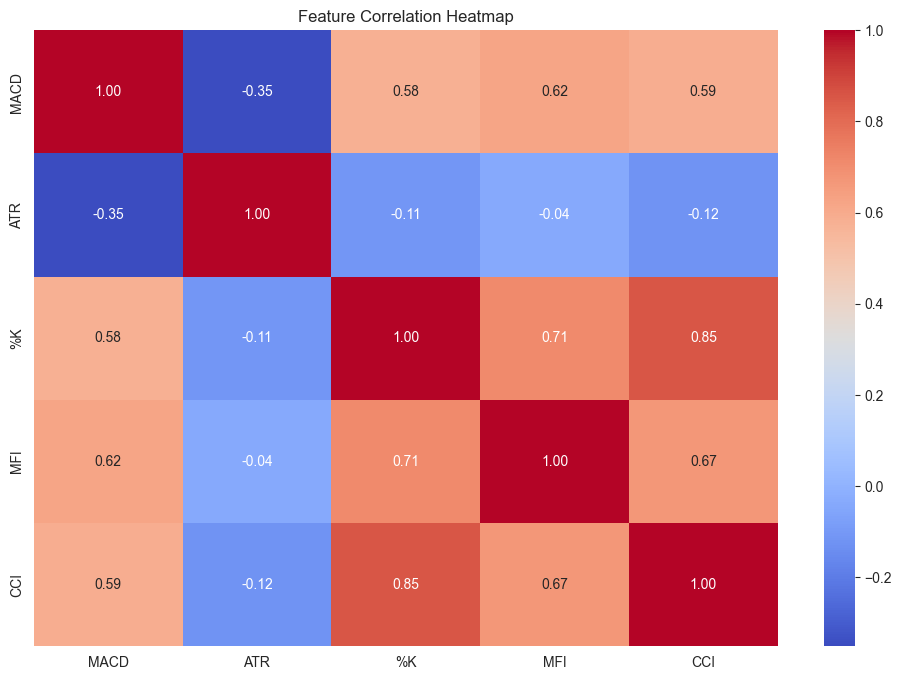

In [10]:
X.hist(figsize=(15, 10), bins=30)
plt.suptitle('Distribution of Selected Features')
plt.tight_layout()
plt.show()

# Boxplot for feature distributions before normalization
plt.figure(figsize=(15, 8))
sns.boxplot(data=X)
plt.title('Feature Boxplots (Before Normalization)')
plt.xticks(rotation=45)
plt.show()

# Compute the correlation matrix
correlation_matrix = X.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Heatmap')
plt.show()

# Prepare the Data for Training and Testing

In [11]:
# X = df.loc[:, (df.columns != 'next_day_price_move') & (df.columns != 'date') & (df.columns != 'close')]
# y = df['next_day_price_move']
# 
# Normalize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# 
# X = scaler.fit_transform(X)
# 
# X

# Exclude the 'date' and 'next_day_price_move' columns before normalization
df_features = df[selected_features]

# Normalize the DataFrame without the 'date' column
df_normalized = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

# Add the 'date' column back to the normalized DataFrame
df_normalized.insert(0, 'date', df['date'].values)

# Move 'next_day_price_move' to the last column
df_normalized['next_day_price_move'] = df['next_day_price_move'].values


print(df_normalized.head())

                 date      MACD       ATR        %K       MFI       CCI  \
0 2020-02-06 09:00:00 -0.726876 -0.687030 -0.013840 -0.201819 -0.435783   
1 2020-02-07 09:00:00 -0.639074 -0.776104  0.354491 -0.233348 -0.326895   
2 2020-02-10 09:00:00 -0.545695 -0.723778  0.515647 -0.143154 -0.425480   
3 2020-02-11 09:00:00 -0.472379 -0.869306  0.646153 -0.188848 -0.147469   
4 2020-02-12 09:00:00 -0.396144 -1.004440  0.731166  0.208680  0.020092   

   next_day_price_move  
0                    2  
1                    2  
2                    0  
3                    2  
4                    0  


In [12]:
df_normalized.dtypes # just checking the dtypes

date                   datetime64[ns]
MACD                          float64
ATR                           float64
%K                            float64
MFI                           float64
CCI                           float64
next_day_price_move             int64
dtype: object

In [13]:
# from sklearn.model_selection import train_test_split
# 
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def create_sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, :-1])  # Include all features except the target
        y.append(data[i + window_size, -1])  # The target is the last column
    return np.array(X), np.array(y)

# Assuming df is your DataFrame and 'next_day_price_move' is the target column
window_size = 20  # Define the size of the sliding window

# Convert the DataFrame to a NumPy array
data = df_normalized.drop(columns=['date']).values

# Create the sliding window data
X, y = create_sliding_window(data, window_size)

# Split the data into training and testing sets
# split_ratio = 0.9
# split_index = int(len(X) * split_ratio)
train_size = int(len(X) * 0.8)
val_size = int(len(X) * 0.1)

# X_train, X_test = X[:split_index], X[split_index:]
# y_train, y_test = y[:split_index], y[split_index:]
X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size + val_size]
y_val = y[train_size:train_size + val_size]

X_test = X[train_size + val_size:]
y_test = y[train_size + val_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (930, 20, 5), y_train shape: (930,)
X_test shape: (117, 20, 5), y_test shape: (117,)


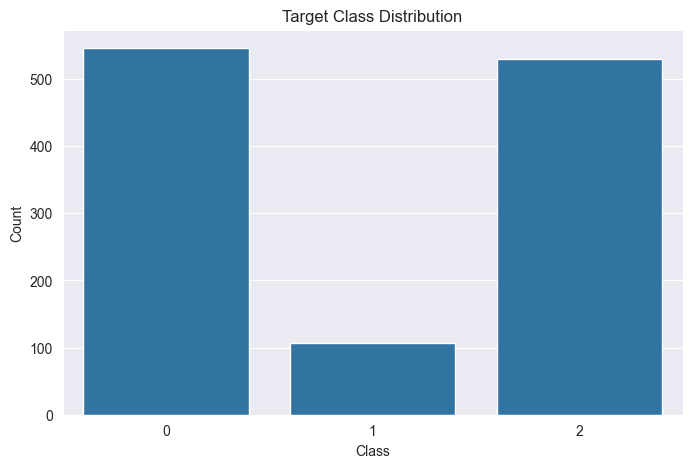

Class Distribution:
next_day_price_move
0    0.461538
2    0.448014
1    0.090448
Name: proportion, dtype: float64


In [14]:
# Plot the distribution of the target variable
plt.figure(figsize=(8, 5))
sns.countplot(x=df_normalized['next_day_price_move'])
plt.title('Target Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# print the class distribution
class_distribution = df_normalized['next_day_price_move'].value_counts(normalize=True)
print("Class Distribution:")
print(class_distribution)

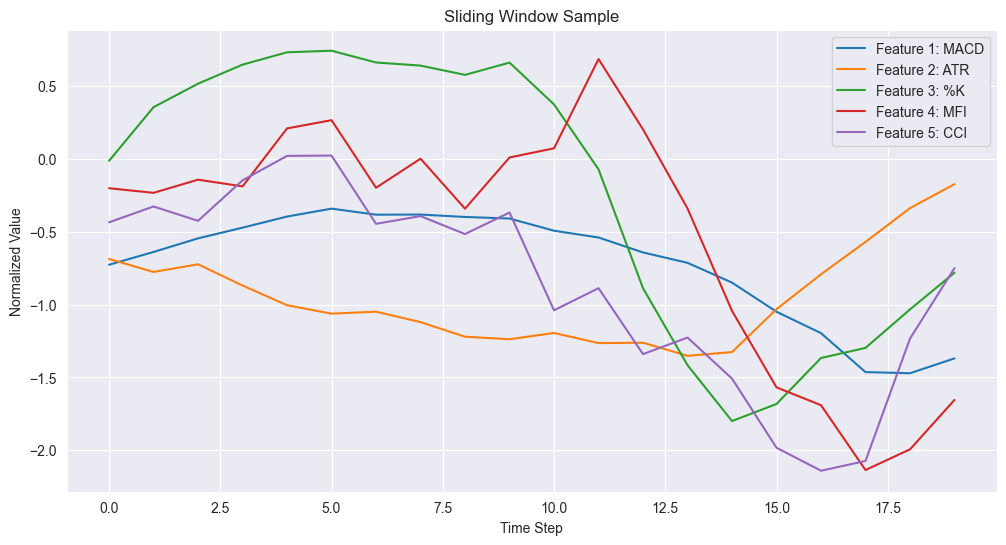

In [15]:
# Visualize a sample sliding window
sample_index = 0  # Change this to visualize different samples
sample_window = X_train[sample_index]

plt.figure(figsize=(12, 6))
for i in range(sample_window.shape[1]):
    plt.plot(sample_window[:, i], label=f'Feature {i+1}: {selected_features[i]}')
plt.title('Sliding Window Sample')
plt.xlabel('Time Step')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

# Visualize the selected features after normalization

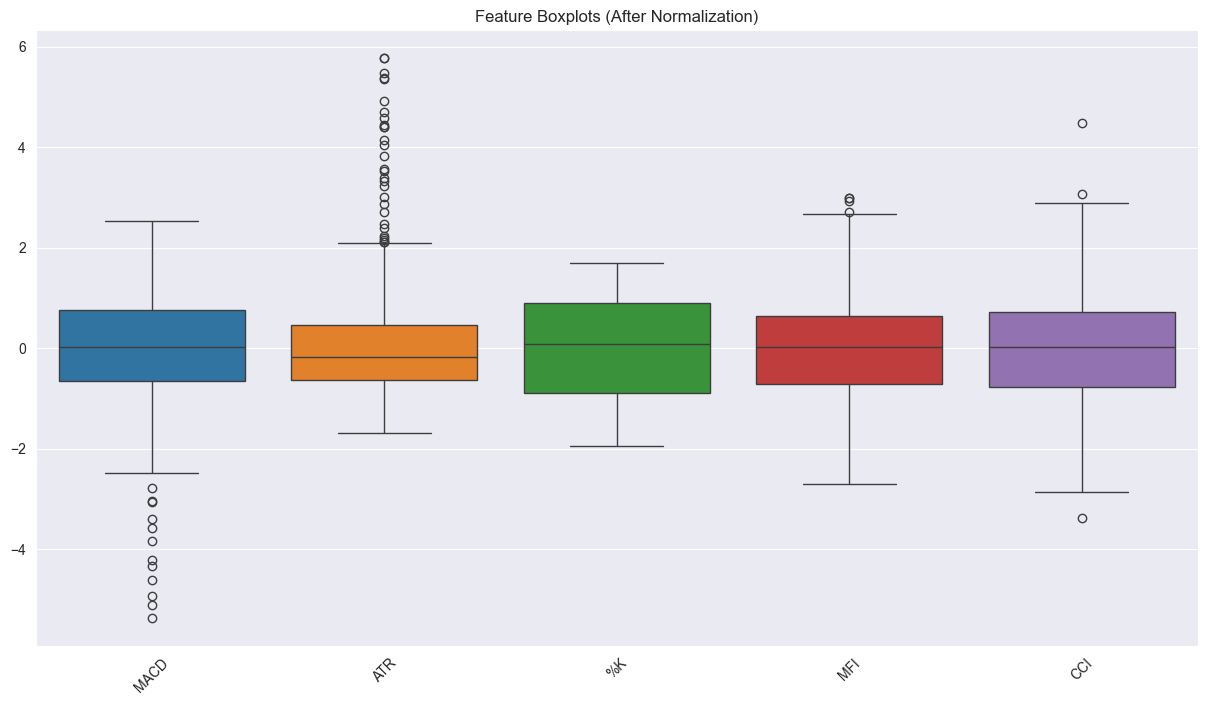

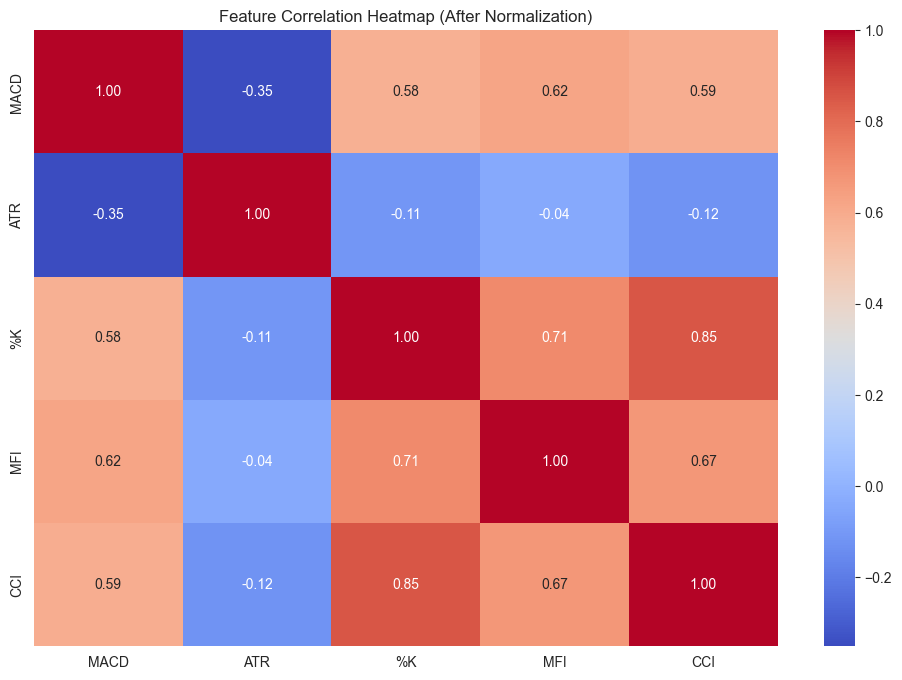

In [16]:
# Boxplot for feature distributions after normalization
plt.figure(figsize=(15, 8))
sns.boxplot(data=df_normalized[selected_features])
plt.title('Feature Boxplots (After Normalization)')
plt.xticks(rotation=45)
plt.show()

# Correlation heatmap after normalization
plt.figure(figsize=(12, 8))
sns.heatmap(df_normalized[selected_features].corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Heatmap (After Normalization)')
plt.show()


# Train and Evaluate the Model with LSTM

In [17]:
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import Callback
import numpy as np
from tensorflow.keras import backend as K
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import f1_score

# Early stop
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# Reduce learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

# Save best model
model_checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Add F1 Score callback (as before)
class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        # Ensure the validation data is set properly
        X_val, y_val = self.validation_data

        # Predict on validation set
        y_pred = self.model.predict(X_val)
        y_true = y_val

        # Calculate predicted classes
        y_pred_classes = tf.argmax(y_pred, axis=1)

        # Calculate and log F1 score
        precision = tf.keras.metrics.Precision()
        recall = tf.keras.metrics.Recall()

        precision.update_state(y_true, y_pred_classes)
        recall.update_state(y_true, y_pred_classes)

        precision_score = precision.result().numpy()
        recall_score = recall.result().numpy()
        f1_score = 2 * (precision_score * recall_score) / (precision_score + recall_score + 1e-7)

        print(f" - val_f1_score: {f1_score:.4f}")

        # Add the F1 score to logs for TensorBoard or other callbacks
        logs['val_f1_score'] = f1_score


f1_callback = F1ScoreCallback(validation_data=(X_val, y_val))


#
# class F1ScoreCallback(Callback):
#     def __init__(self, validation_data):
#         super().__init__()
#         self.validation_data = validation_data
#
#     def on_epoch_end(self, epoch, logs=None):
#         val_X, val_y_true = self.validation_data
#         val_y_pred = self.model.predict(val_X, verbose=0).argmax(axis=1)
#         score = f1_score(val_y_true, val_y_pred, average='macro')
#         print(f"\nEpoch {epoch+1} F1 Score (macro): {score:.4f}")


def focal_loss(gamma=2., alpha=[1., 0.5, 1.]):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.one_hot(y_true, depth=3)
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        loss = -y_true * alpha * K.pow(1 - y_pred, gamma) * K.log(y_pred)
        return K.mean(K.sum(loss, axis=-1))
    return focal_loss_fixed

In [18]:
import tensorflow as tf
from keras import Sequential
from keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

# Define the LSTM model
model = Sequential()

# First LSTM block
model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(BatchNormalization())  # Normalize activations
model.add(Dropout(0.5))

# Second LSTM block
model.add(LSTM(64, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Dense layer
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Output layer
model.add(Dense(3, activation='softmax'))

# Compile the model
model.summary()
model.compile(optimizer=Adam(),
              # loss=focal_loss(gamma=2., alpha=[1.0, 0.3, 1.0]),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


# history = model.fit(X_train, y_train, epochs=50, batch_size=32)
# f1_callback = F1ScoreCallback(validation_data=(X_val, y_val))
# Example: down=1.0, same=0.3, up=1.0
class_weights = {0: 1.0, 1: 0.3, 2: 1.0}

class_weights = dict(enumerate(class_weights))


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr, model_checkpoint, f1_callback]
)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            17920     
                                                                 
 batch_normalization (BatchN  (None, 20, 64)           256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 batch_normalization_1 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

# Evaluate the model

In [19]:
y_pred = np.argmax(model.predict(X_test), axis=1)

# Compare predictions with actual values
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['Down', 'Same', 'Up']))

4/4 [==============================] - 0s 6ms/step
              precision    recall  f1-score   support

        Down       0.46      0.31      0.37        55
        Same       0.00      0.00      0.00         9
          Up       0.51      0.77      0.62        53

    accuracy                           0.50       117
   macro avg       0.32      0.36      0.33       117
weighted avg       0.45      0.50      0.45       117



C:\Users\user\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\user\miniconda3\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Plot learning curves

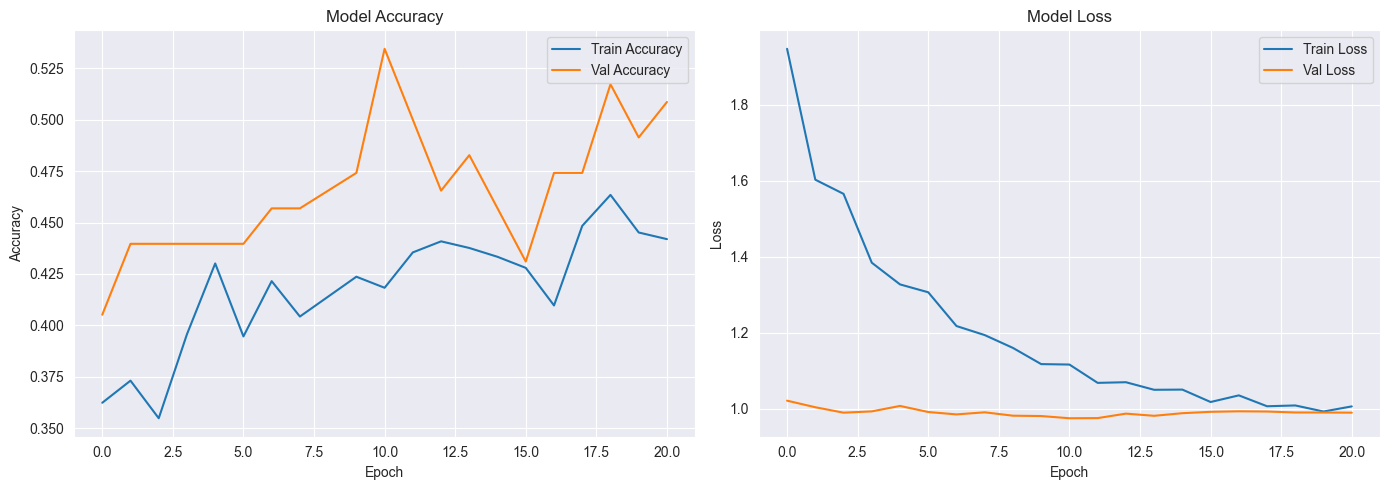

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy and loss
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

4/4 [==============================] - 0s 6ms/step


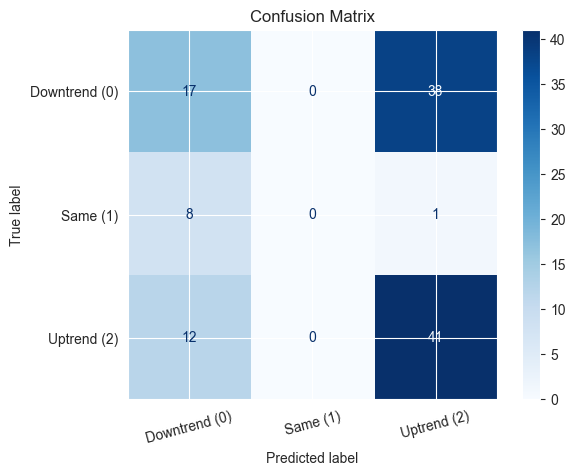

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test set
y_pred_probs = model.predict(X_test)
y_pred = y_pred_probs.argmax(axis=1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = ['Downtrend (0)', 'Same (1)', 'Uptrend (2)']

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.xticks(rotation=15)
plt.show()


# ANOTHER TESTING

In [22]:
# def create_sliding_window(data, window_size):
#     X, y = [], []
#     for i in range(len(data) - window_size):
#         X.append(data[i:i + window_size, :-1])  # Include all features except the target
#         y.append(data[i + window_size, -1])  # The target is the last column
#     return np.array(X), np.array(y)
#
# # Ensure normalized data is used
# data = df_normalized.drop(columns=['date']).values
#
# # Test different window sizes
# window_sizes = [5, 10, 20, 50]
# results = {}
#
# for window_size in window_sizes:
#     X, y = create_sliding_window(data, window_size)
#     split_index = int(len(X) * 0.8)
#     X_train, X_temp = X[:split_index], X[split_index:]
#     y_train, y_temp = y[:split_index], y[split_index:]
#
#     # Further split temp set into validation and test sets
#     val_split = int(len(X_temp) * 0.5)
#     X_val, X_test = X_temp[:val_split], X_temp[val_split:]
#     y_val, y_test = y_temp[:val_split], y_temp[val_split:]
#
#     # Train the model
#     model = Sequential()
#     model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
#
#     model.add(LSTM(64, return_sequences=False))
#     model.add(BatchNormalization())
#     model.add(Dropout(0.3))
#
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.3))
#
#     model.add(Dense(3, activation='softmax'))
#     model.compile(optimizer="adam",
#                   loss="sparse_categorical_crossentropy",
#                   metrics=["accuracy"])
#     history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, verbose=0, callbacks=[reduce_lr, model_checkpoint])
#
#     # Evaluate the model
#     loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
#     results[window_size] = accuracy
#
# # Print results
# print("Window Size vs Accuracy:", results)

In [23]:
# import tensorflow as tf
# print(tf.config.list_physical_devices('GPU'))